# GEDI Level 4A Search and Discovery

### _Extract geometries of selected counties from national map of Kenya_

In [1]:
import os
import geopandas

path = os.path.join( os.getcwd(), 'aois/kenya' )
country = geopandas.read_file( os.path.join( path, 'county.shp' ) ) 
country.head(5)

,fid,OBJECTID,ID,Name,Code,Shape_Leng,Shape_Area,Area,geometry
0,1.0,1.0,1.0,Mombasa,MBA,0.885586,0.023325,2.864232e+08,"POLYGON ((39.68250 -4.05829, 39.68292 -4.05579..."
1,2.0,2.0,2.0,Kwale,KLE,4.284182,0.758266,9.309279e+09,"POLYGON ((39.32031 -3.56799, 39.31873 -3.57269..."
2,3.0,3.0,3.0,Kilifi,KLF,5.333080,1.025338,1.260187e+10,"POLYGON ((39.71051 -3.90869, 39.71393 -3.90509..."
3,4.0,4.0,4.0,Tana River,TAN,10.280449,3.184213,3.917746e+10,"POLYGON ((39.02753 -0.00153, 39.03168 -0.00171..."
4,5.0,5.0,5.0,Lamu,LAU,3.744689,0.743743,9.148879e+09,"POLYGON ((41.07727 -2.38000, 40.99213 -2.44751..."


In [2]:
def getCounties( names ):         
    return country[ country [ 'Name' ].isin( names ) ]
    
counties = getCounties( ['Kiambu', 'Laikipia', 'Nakuru', 'Nyandarua', 'Nyeri' ] )
counties

,fid,OBJECTID,ID,Name,Code,Shape_Leng,Shape_Area,Area,geometry
17,18.0,18.0,18.0,Nyandarua,NDR,3.481799,0.265403,3.266788e+09,"POLYGON ((36.50371 0.09745, 36.51147 0.08911, ..."
18,19.0,19.0,19.0,Nyeri,NER,2.980290,0.270907,3.334542e+09,"POLYGON ((37.07788 0.00208, 37.08051 -0.00311,..."
21,22.0,22.0,22.0,Kiambu,KBU,3.087325,0.206571,2.542264e+09,"POLYGON ((36.64850 -1.29840, 36.63611 -1.29602..."
30,31.0,31.0,31.0,Laikipia,LKP,5.222806,0.774708,9.535699e+09,"POLYGON ((36.82990 0.82233, 36.83112 0.81952, ..."
31,32.0,32.0,32.0,Nakuru,NKU,6.340543,0.607218,7.473953e+09,"POLYGON ((36.25928 0.06207, 36.25653 0.05847, ..."


In [3]:
#import contextily as ctx

#ax = country.to_crs(3857).plot( figsize=(15, 15), alpha=0.3, edgecolor='black' )
#counties.to_crs(3857).plot( ax=ax, alpha=0.5, facecolor='red', edgecolor='black' )
#ctx.add_basemap(ax, zoom=8 )

### _Dissolve county geometries into single polygon ready for metadata search_

C:\Users\crwil\AppData\Local\Temp/ipykernel_51008/1020477571.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties['geometry'] = counties['geometry'].buffer(0.001)
C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

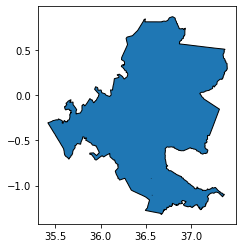

In [4]:
# expand before dissolve to ensure boundaries overlap
counties['geometry'] = counties['geometry'].buffer(0.001)

# dissolve county polygons into single polygons 
counties = counties.dissolve( aggfunc='sum')
counties.plot( edgecolor='black' )

In [5]:
# orient point coordinates clockwise
from shapely.ops import orient
counties.geometry = counties.geometry.apply(orient, args=(1,))

In [6]:
#import json
#print ( json.loads( counties.to_json() )[ 'features'][ 0 ][ 'geometry'][ 'coordinates'][] )

### _Entry in NASA EarthData catalogue for GEDI Level 4A datasets_

In [7]:
# constants
doi = '10.3334/ORNLDAAC/2056' # GEDI L4A DOI 
base_url = 'https://cmr.earthdata.nasa.gov/search/' # CMR API base url

In [8]:
import requests

doisearch = base_url + f'collections.json?doi={doi}'
requests.get(doisearch).json()

{'feed': {'updated': '2022-05-02T14:38:45.752Z',
  'id': 'https://cmr.earthdata.nasa.gov:443/search/collections.json?doi=10.3334/ORNLDAAC/2056',
  'title': 'ECHO dataset metadata',
  'entry': [{'processing_level_id': '4',
    'boxes': ['-53 -180 53.99 180'],
    'time_start': '2019-04-17T23:00:00.000Z',
    'version_id': '2.1',
    'updated': '2022-03-23T21:29:30.000Z',
    'dataset_id': 'GEDI L4A Footprint Level Aboveground Biomass Density, Version 2.1',
    'has_spatial_subsetting': False,
    'has_transforms': False,
    'has_variables': False,
    'data_center': 'ORNL_CLOUD',
    'short_name': 'GEDI_L4A_AGB_Density_V2_1_2056',
    'organizations': ['ORNL_DAAC'],
    'title': 'GEDI L4A Footprint Level Aboveground Biomass Density, Version 2.1',
    'coordinate_system': 'CARTESIAN',
    'summary': "This dataset contains Global Ecosystem Dynamics Investigation (GEDI) Level 4A (L4A) Version 2 predictions of the aboveground biomass density (AGBD; in Mg/ha) and estimates of the prediction

### _Generalised function to download GEDI Level 4A metadata catalogue records_

In [9]:
import pandas as pd
from shapely.geometry import MultiPolygon, Polygon

def getGranuleMetadata( concept_id, aoi ):

    page_num = 1
    page_size = 2000 # CMR page size limit
    
    geojson = {"shapefile": ( "search.json", aoi.geometry.to_json(), "application/geo+json")}
    metadata = list()
    
    while True:
    
        # defining parameters
        cmr_param = {
            "collection_concept_id": concept_id, 
            "page_size": page_size,
            "page_num": page_num,
            "simplify-shapefile": 'true' # this is needed to bypass 5000 coordinates limit of CMR
        }
    
        search = base_url + 'granules.json'
        response = requests.post( search, data=cmr_param, files=geojson)
        granules = response.json()['feed']['entry']
    
        if granules:
            
            # iterate through granules
            for g in granules:
                                
                # capture info in dictionary
                info = { 'url' : '', 'geometry' : '', 'size' : float(g['granule_size']) }

                # iterate through multiple polygons
                if 'polygons' in g:

                    polygons = []
                    for polygon in g['polygons']:
                        i=iter(polygon[0].split(" "))

                        # append to list
                        ltln = list(map(" ".join,zip(i,i)))
                        polygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))

                    # combine polygons into single object
                    info[ 'geometry' ] = MultiPolygon( polygons )

                # get dataset url
                for links in g['links']:
                    if 'title' in links and links['title'].startswith('Download') and links['title'].endswith('.h5'):
                        info[ 'url' ] = links['href']

                # add to list        
                metadata.append( info )
               
            page_num += 1
        
        else: 
            # end of granule search
            break
           
    # construct metadata geodataframe
    df = geopandas.GeoDataFrame( metadata )
    df.crs = "EPSG:4326"
    return df.drop_duplicates( subset=['url'] )

In [10]:
# retrieve metadata records
concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']
granules = getGranuleMetadata( concept_id, counties )

print ( 'Datasets available : ', len( granules ) )
print ( 'Total file size (MB): ', granules['size'].sum())

Datasets available :  263
Total file size (MB):  53175.546705


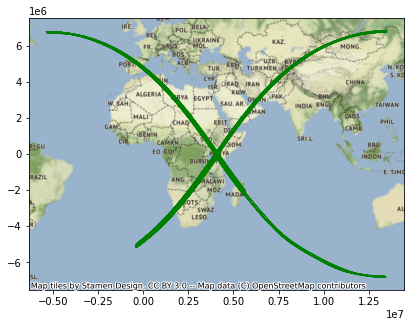

In [11]:
# plot granule geometries on worldmap
import contextily as ctx
ax=granules.to_crs(epsg=3857).plot(figsize=(10, 5),edgecolor='green')
ctx.add_basemap(ax)

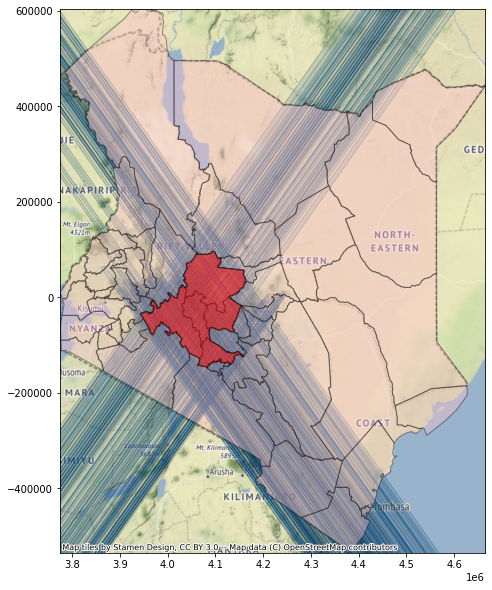

In [12]:
# plot granule geometries
ax=granules.to_crs(epsg=3857).plot(figsize=(15, 10), alpha=0.2, edgecolor='black' )
minx, miny, maxx, maxy = country.to_crs(epsg=3857).total_bounds
ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)

# plot country, countries and basemap
country.to_crs(3857).plot( ax=ax, alpha=0.4, facecolor='pink', edgecolor='black' )
counties.to_crs(3857).plot( ax=ax, alpha=0.5, facecolor='red', edgecolor='black' )
ctx.add_basemap(ax)

In [13]:
# write urls to csv
granules.to_csv('granules.txt', columns = ['url'], index=False, header=False )

wget --http-user=chris010970 --http-password=&VxEos00 --keep-session-cookies http://e4ftl01.cr.usgs.gov/ASTT/AST_L1T.003/2016.09.11/AST_L1T_00309112016020239_20160912100405_5264_QA.txt
 